In [69]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

#Data Loading & Cleaning
print("--- Loading Data ---")
df = pd.read_csv("data/DataSet.csv")

#Clean TotalCharges and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = pd.to_numeric(df['SeniorCitizen'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

#Drop ID and normalize categorical values
df.drop('customerID', axis=1, inplace=True)
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

print(f"Data Shape: {df.shape}")
print(f"Class Distribution:\n{df['Churn'].value_counts()}")

# Preprocessing Setup
X = df.drop('Churn', axis=1)
y = LabelEncoder().fit_transform(df['Churn'])

#Identify columns
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()


print(f"Numerical Columns: {num_cols}")
print(f"Categorical Columns: {cat_cols}")

#Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# Pipeline Construction (Preprocessing -> SMOTE -> Model)
# Using LightGBM as it generally outperforms other models on tabular churn data
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1 , class_weight='balanced'))
])

# Hyperparameter Tuning
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__num_leaves': [20, 30, 50],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

print("--- Starting Hyperparameter Tuning ---")
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=30, 
    cv=3, 
    scoring='f1_macro',
    verbose=0,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

print(f"Best Parameters: {search.best_params_}")

#Evaluation
print("--- Evaluating Best Model ---")
y_pred = best_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save Model
print("--- Saving Model ---")
joblib.dump(best_model, 'data/best_churn_model.pkl')
print("Model saved as 'data/best_churn_model.pkl'")

--- Loading Data ---
Data Shape: (7032, 20)
Class Distribution:
Churn
No     5163
Yes    1869
Name: count, dtype: int64
Numerical Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
--- Starting Hyperparameter Tuning ---
Best Parameters: {'classifier__subsample': 1.0, 'classifier__num_leaves': 30, 'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.8}
--- Evaluating Best Model ---
Confusion Matrix:
[[773 260]
 [ 90 284]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1033
           1       0.52      0.76      0.62       374

    accuracy                 

In [70]:
#Evaluation
print("--- Evaluating Best Model ---")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_proba = np.where(y_pred_proba > 0.49, 1, 0)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_proba))

--- Evaluating Best Model ---
Confusion Matrix:
[[767 266]
 [ 86 288]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.77      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407




Confusion Matrix (Raw Counts):
                 Predicted No Churn  Predicted Churn
Actual No Churn                 773              260
Actual Churn                     90              284


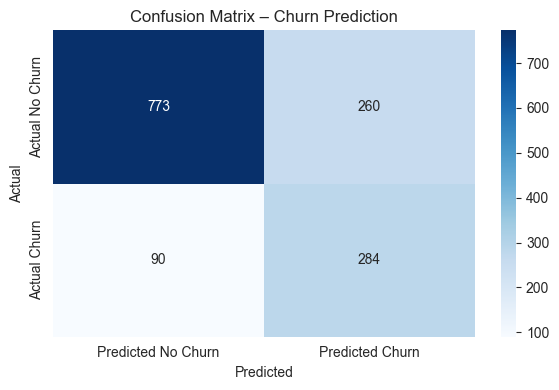

In [71]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm,
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"]
)

print("\nConfusion Matrix (Raw Counts):")
print(cm_df)

# ------------------------------------------------
# Plot Raw Confusion Matrix
# ------------------------------------------------
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix – Churn Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Confusion Matrix (Normalized):
                 Predicted No Churn  Predicted Churn
Actual No Churn               0.748            0.252
Actual Churn                  0.241            0.759


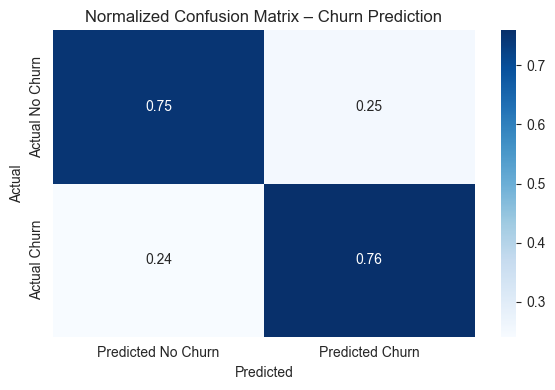

In [72]:
# ------------------------------------------------
# Normalized Confusion Matrix
# ------------------------------------------------
cm_norm = cm / cm.sum(axis=1, keepdims=True)

cm_norm_df = pd.DataFrame(
    cm_norm,
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"]
)

print("\nConfusion Matrix (Normalized):")
print(cm_norm_df.round(3))

# ------------------------------------------------
# Plot Normalized Confusion Matrix
# ------------------------------------------------
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_norm_df,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)
plt.title("Normalized Confusion Matrix – Churn Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()